In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import zipfile
import os
import glob
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
net = torchvision.models.resnet50(pretrained=True)
for params in net.parameters():
    params.requires_grad_ = False
nr_filters = net.fc.in_features
net.fc = nn.Sequential(nn.Linear(nr_filters, 1), nn.Sigmoid())

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 283MB/s]


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
device

device(type='cuda', index=0)

In [4]:
base_dir = '../input/dogs-vs-cats'
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
with zipfile.ZipFile(os.path.join(base_dir, 'test1.zip')) as test_zip:
    test_zip.extractall('../data')

train_dir = '../data/train'
test_dir = '../data/test'

In [5]:
all_train_files = glob.glob(os.path.join(train_dir, '*.jpg'))
train_list, val_list = train_test_split(all_train_files, random_state=42)
print(len(train_list))
print(len(val_list))

18750
6250


In [6]:
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

In [7]:
class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
        transforms.RandomErasing(),
    ]
)
batch_size = 10

trainset = DogVsCatDataset(train_list, transform=transform)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=8
)

testset = DogVsCatDataset(val_list, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=8
)

In [9]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
criterion = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(net.fc.parameters()) 

In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

In [14]:
for epoch in range(10):
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for i, data in enumerate(tqdm(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels.unsqueeze(1).float()).sum().item()
        train_total += labels.size(0)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    val_loss = 0.0
    val_correct = 0
    val_total = 0
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        val_loss += loss.item()
        predicted = (outputs > 0.5).float()
        val_correct += (predicted == labels.unsqueeze(1).float()).sum().item()
        val_total += labels.size(0)

    train_loss.append(running_loss / len(trainloader))
    test_loss.append(val_loss / len(testloader))
    train_acc.append(train_correct / train_total)
    test_acc.append(val_correct / val_total)

    print(f"[{epoch + 1}, {i + 1:5d}]")
    print(f"\tloss: {train_loss[-1]:.3f} val loss: {test_loss[-1]:.3f}")
    print(f"\taccuracy: {train_acc[-1]:.3f} val accuracy: {test_acc[-1]:.3f}")

Epoch: 1


  0%|          | 0/1875 [00:00<?, ?it/s]

[1,   625]
	loss: 0.530 val loss: 0.526
	accuracy: 0.941 val accuracy: 0.941
Epoch: 2


  0%|          | 0/1875 [00:00<?, ?it/s]

[2,   625]
	loss: 0.531 val loss: 0.527
	accuracy: 0.940 val accuracy: 0.943
Epoch: 3


  0%|          | 0/1875 [00:00<?, ?it/s]

[3,   625]
	loss: 0.530 val loss: 0.528
	accuracy: 0.941 val accuracy: 0.935
Epoch: 4


  0%|          | 0/1875 [00:00<?, ?it/s]

[4,   625]
	loss: 0.530 val loss: 0.527
	accuracy: 0.942 val accuracy: 0.938
Epoch: 5


  0%|          | 0/1875 [00:00<?, ?it/s]

[5,   625]
	loss: 0.530 val loss: 0.527
	accuracy: 0.940 val accuracy: 0.943
Epoch: 6


  0%|          | 0/1875 [00:00<?, ?it/s]

[6,   625]
	loss: 0.531 val loss: 0.527
	accuracy: 0.940 val accuracy: 0.939
Epoch: 7


  0%|          | 0/1875 [00:00<?, ?it/s]

[7,   625]
	loss: 0.531 val loss: 0.526
	accuracy: 0.938 val accuracy: 0.945
Epoch: 8


  0%|          | 0/1875 [00:00<?, ?it/s]

[8,   625]
	loss: 0.530 val loss: 0.525
	accuracy: 0.941 val accuracy: 0.943
Epoch: 9


  0%|          | 0/1875 [00:00<?, ?it/s]

[9,   625]
	loss: 0.529 val loss: 0.525
	accuracy: 0.943 val accuracy: 0.946
Epoch: 10


  0%|          | 0/1875 [00:00<?, ?it/s]

[10,   625]
	loss: 0.530 val loss: 0.527
	accuracy: 0.941 val accuracy: 0.940


[0.5467778089205424, 0.5370370124022166, 0.534513412396113, 0.5341632370313009, 0.5333208859284719, 0.5325319857438405, 0.5320534995237987, 0.5335197917620341, 0.5323674152374268, 0.5305912973562876]
[0.5350596535205842, 0.5299977269649505, 0.5303201741218567, 0.533302233505249, 0.5271622486591339, 0.5269263611793518, 0.5288195643901825, 0.5306591539859772, 0.5278265954494477, 0.5273659524440766]
[0.9161066666666666, 0.9287466666666667, 0.93376, 0.9346133333333333, 0.9354666666666667, 0.93776, 0.93776, 0.9341866666666667, 0.9361066666666666, 0.9405866666666667]
[0.9368, 0.9368, 0.92784, 0.91712, 0.944, 0.94, 0.93328, 0.94224, 0.93392, 0.94]


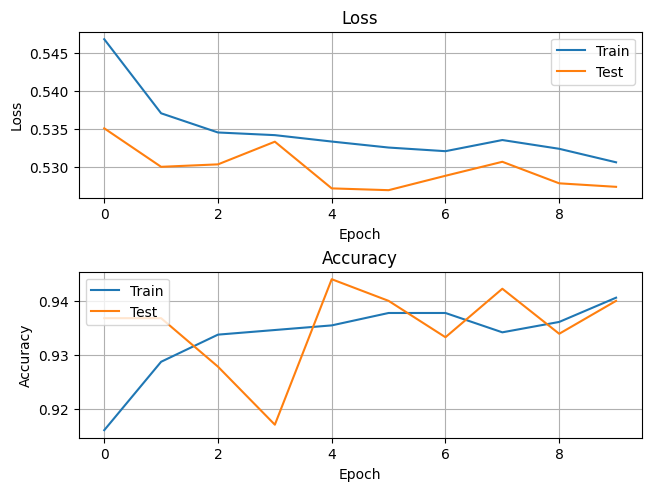

In [11]:
fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(train_loss, label="Train")
axs[0].plot(test_loss, label="Test")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")
axs[0].set_title("Loss")
axs[0].grid(True)

axs[1].plot(train_acc, label="Train")
axs[1].plot(test_acc, label="Test")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc="upper left")
axs[1].set_title("Accuracy")
axs[1].grid(True)

print(train_loss)
print(test_loss)
print(train_acc)
print(test_acc)

In [12]:
print("Finished Training")
torch.save(net.state_dict(), "./cat_dog_net.pth")

Finished Training
